#  Benchmarking variant effect predictions of various models

We assess the accuracy of variant effect predictions from a collection of models by comparing to those generated experimentally through saturation mutagenesis via MPRA assays in [Kircher _et al_ (2019)](https://doi.org/10.1038/s41467-019-11526-w).

## Setup

### Imports

In [1]:
import pandas as pd
import duckdb
from pathlib import Path

import sys
sys.path.append('..')

### Models and paths

#### Models to include

In [2]:
MODELS = ['K562', 'A549-DMSO']

#### Paths to data and databases

In [3]:
PROJECT_ROOT = Path('/hpc/group/igvf')
DATA_ROOT = Path("../../igvf-pm")
DB_ROOT = PROJECT_ROOT / 'db'
MUT_PRED_DBs = {k: DB_ROOT / f'Kircher-2019_{k}.parquet' for k in MODELS}
BENCHMARK_DIR = DATA_ROOT / 'benchmarks'
DATA_DIR = BENCHMARK_DIR / 'Kircher_et_al_2019'
GKSVM_PREDS = BENCHMARK_DIR / 'MPRA-deltaSVM' / 'deltasvm_saturated_mutations.tsv'

## Load Kircher _et al_ (2019) data files

In [4]:
from starrutil.mprautil import read_kircher_mpra_data
mpra_data = read_kircher_mpra_data(DATA_DIR)

In [5]:
kircher_nmut = len(mpra_data.select(['chrom', 'allele_pos', 'alt_allele']).unique().collect())
print(f"Total number of mutations with MPRA results: {kircher_nmut:,}")

Total number of mutations with MPRA results: 29,444


## Merge with variant effect predictions from models

### Variant effect predictions from _in-silico_ saturated mutagenesis of Kircher _et al_ 2019 regions

In [6]:
mutpreds = {}
for model, db in MUT_PRED_DBs.items():
    mutpreds[model] = duckdb.read_parquet(str(db))
    print(f"Predictions from {model}: {mutpreds[model].count('chrom').fetchall()[0][0]:,}")

Predictions from K562: 29,532
Predictions from A549-DMSO: 29,532


### Join by chromosomal position and alternative allele

Kircher _et al_ (2019) use not only the effect size, but also the P-value and Tags columns for filtering. We therefore include both here.

In [7]:
from starrutil.mprautil import join_preds_to_mpra

In [8]:
bk_dfs = {}
for model, mutdb in mutpreds.items():
    bk_dfs[model] = join_preds_to_mpra(mutdb, mpra_data, alt_col='allele')

### Add in deltaSVM predictions

In [11]:
deltasvm_preds = pd.read_csv(GKSVM_PREDS, sep='\t', index_col=False)
deltasvm_df = join_preds_to_mpra(deltasvm_preds, mpra_data, alt_col='alt_allele')
bk_dfs['deltaSVM'] = deltasvm_df

### Number of matched predictions sanity check

In [12]:
for model, df in bk_dfs.items():
    print(f"Number of MPRA results matched with model {model} predictions: {len(bk_dfs[model]):,} ({len(bk_dfs[model])/kircher_nmut:.1%})")

Number of MPRA results matched with model K562 predictions: 29,444 (100.0%)
Number of MPRA results matched with model A549-DMSO predictions: 29,444 (100.0%)
Number of MPRA results matched with model deltaSVM predictions: 29,444 (100.0%)


### Reference allele sanity check

For every position, the reference alleles between Kircher _et al_ and model predictions should be the same.

In [13]:
for model, bk_df in bk_dfs.items():
    ref_mismatched = bk_df.loc[bk_df['ref_allele'] != bk_df['pred_ref_allele']]
    print(f"Ref allele mismatches for {model}: {len(ref_mismatched):,}")

Ref allele mismatches for K562: 0
Ref allele mismatches for A549-DMSO: 0
Ref allele mismatches for deltaSVM: 0


## ROC display and AUC

### Define positive and negative classes

Kircher _et al_ (2019) calculate a p-value based on a linear regression model, and label positives (mutations having a significant effect) based on a p-value cut-off (p≤1e-5). For the negative class (mutations without a significant effect) a cut-off on absolute effect size (at 0.05) is used. (Strictly speaking, Kircher _et al_ only give _"$log_2$ expression effect ≤ 0.05"_, but we assume they meant _absolute_ expression effect.)

Additionally, labeling classes (as either a positive or a negative) requires a minimum Tag count. We use 10 as recommended in Kircher _et al_ (2019).

Kircher _et al_ (2019) don't explicitly mention whether there is a p-value cutoff as well for the negative class. We use the same cutoff as for the positive class.

Note that this approach will leave some mutations unlabeled (those with low Tag count, and those with absolute effect size > 0.05 but p > cutoff).

In [14]:
from starrutil.mprautil import add_class_labels

In [15]:
Pval_pos = 1e-5
Pval_neg = 1e-5
effect_neg = 0.05
pos_label = f"MPRA p≤{Pval_pos}"
neg_label = f"MPRA p>{Pval_neg}"

In [16]:
bk_dfs = {
    model: add_class_labels(bk_df,
                            Pval_pos=Pval_pos,
                            Pval_neg=Pval_neg,
                            abs_effect_neg=effect_neg,
                            pos_label=pos_label, neg_label=neg_label).dropna(subset=['label'])
    for model, bk_df in bk_dfs.items()
}

### Class counts by model and region type

In [17]:
bk_df = pd.concat(bk_dfs.values(), keys=bk_dfs.keys(), names=['model'])
bk_df.groupby(['model', 'region_type', 'label'])['chrom'].count()

model      region_type  label       
A549-DMSO  Enhancers    MPRA p>1e-05    7237
                        MPRA p≤1e-05    2770
           Promoters    MPRA p>1e-05    3418
                        MPRA p≤1e-05    1987
K562       Enhancers    MPRA p>1e-05    7237
                        MPRA p≤1e-05    2770
           Promoters    MPRA p>1e-05    3418
                        MPRA p≤1e-05    1987
deltaSVM   Enhancers    MPRA p>1e-05    7237
                        MPRA p≤1e-05    2772
           Promoters    MPRA p>1e-05    3418
                        MPRA p≤1e-05    1987
Name: chrom, dtype: int64

In [18]:
bk_df.loc[bk_df['region'] == 'PKLR'].groupby(['model', 'label'])['chrom'].count()

model      label       
A549-DMSO  MPRA p>1e-05     52
           MPRA p≤1e-05    289
K562       MPRA p>1e-05     52
           MPRA p≤1e-05    289
deltaSVM   MPRA p>1e-05     52
           MPRA p≤1e-05    289
Name: chrom, dtype: int64

### Scatter plots of predictions versus MPRA effect size

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

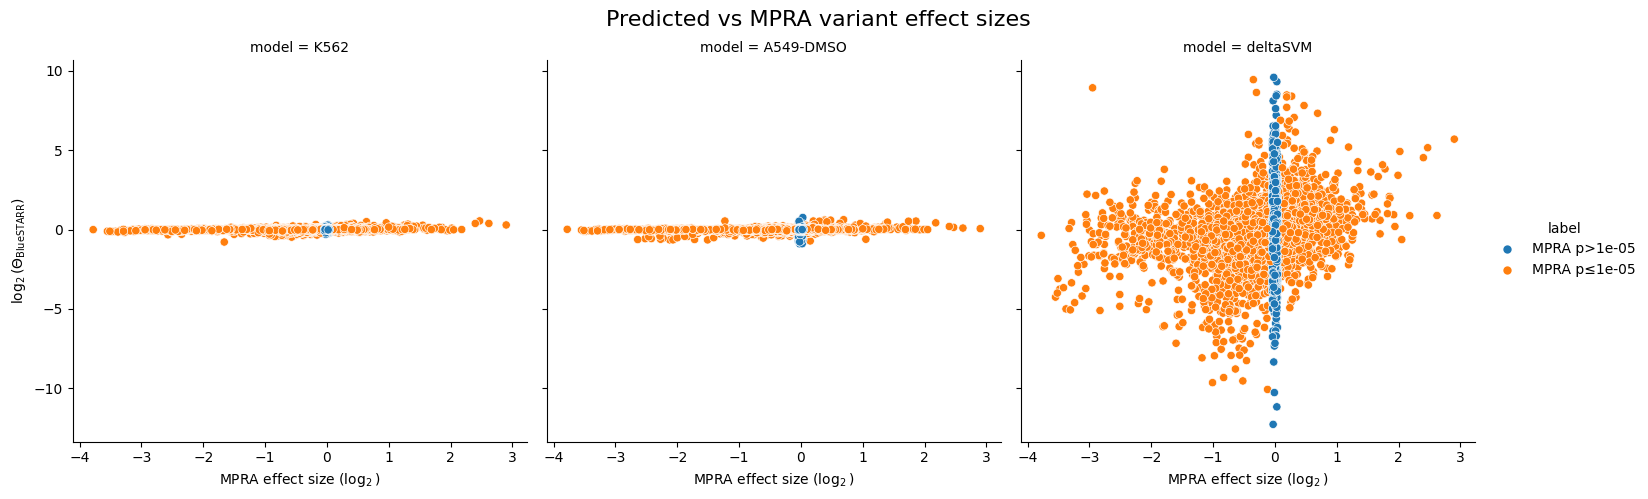

In [21]:
g = sns.relplot(data=bk_df, x='mpra_max_log2effect', y='log2FC',
                hue='label', col='model', col_wrap=3, kind='scatter')
g.set_axis_labels('MPRA effect size ($\log_2)$', '$\log_2(\Theta_{\mathrm{BlueSTARR}})$')
g.figure.suptitle('Predicted vs MPRA variant effect sizes', fontsize=16)
g.figure.subplots_adjust(top=0.88)

### AUC-ROC calculation

Kircher _et al_ in Supplementary Tables 17-18 give AUC scores for a variety of classifiers, but in addition to the filtering (Tags≥10; P≤1e-5 for TPs; P>1e-5 and $\log_2$(expression effect) < 0.05 for TNs) their ROC computation uses only the top _N_, with $N \in \{200, 500, 1000\}$, variants with "highest expression effect", which we assume to be the absolute expression effect size in $\log_2$ space.

In [22]:
from sklearn.metrics import roc_auc_score
from collections import namedtuple
import numpy as np

In [23]:
def generate_aucs(bk_dfs: dict):
    rowtuple = namedtuple('AUCresult', ['model', 'subset', 'auroc'])
    subsets = np.insert(np.sort(next(iter(bk_dfs.values()))['region_type'].unique()),
                             0, 
                             ['All data', 'PKLR'])
    for model, bk_df in bk_dfs.items():
        for subset_key in subsets:
            if subset_key == 'All data':
                subset = bk_df
            elif subset_key == 'PKLR':
                subset = bk_df[bk_df['region'] == subset_key]
            else:
                subset = bk_df[bk_df['region_type'] == subset_key]
            auc = roc_auc_score(subset['label'], subset['log2FC'].abs())
            yield rowtuple(model=model, subset=subset_key, auroc=auc)


In [24]:
aucs = pd.DataFrame(generate_aucs(bk_dfs))

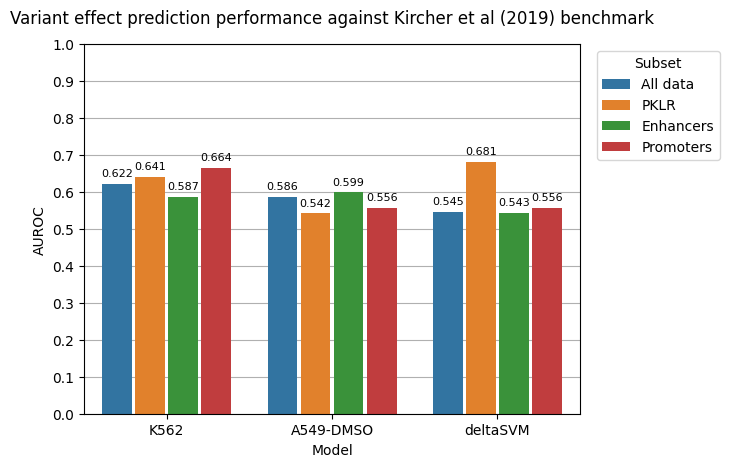

In [36]:
ax = sns.barplot(data=aucs, x='model', y='auroc', hue='subset', gap=0.1)
ax.set_ylabel('AUROC')
ax.set_xlabel('Model')
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.01, 0.1, ))
ax.yaxis.grid(True)
ax.set_axisbelow(True)
ax.legend(title='Subset', bbox_to_anchor=(1.02, 1), loc='upper left')
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', label_type='edge', padding=4, fontsize=8)
_ = ax.set_title('Variant effect prediction performance against Kircher et al (2019) benchmark', pad=15)

In [50]:
def generate_aucs_by(bk_dfs: dict, subset_by: str = 'region', all_name: str = 'All data'):
    rowtuple = namedtuple('AUCresult', ['model', 'subset', 'auroc'])
    subset_keys = np.insert(np.sort(next(iter(bk_dfs.values()))[subset_by].unique()), 0, [all_name])
    for model, bk_df in bk_dfs.items():
        for subset_key in subset_keys:
            if subset_key == all_name:
                subset = bk_df
            else:
                subset = bk_df[bk_df[subset_by] == subset_key]
            auc = roc_auc_score(subset['label'], subset['log2FC'].abs())
            yield rowtuple(model=model, subset=subset_key, auroc=auc)


In [ ]:
# UC88 is among the enhancer regions (which are generally less conserved than promoter regions)
# but it is an ultra-conserved region, so one might want to exclude it from the analysis (i.e., enhancers)
bk_dfs_filtered = {
    model: bk_df.loc[bk_df['region'] != 'UC88'] for model, bk_df in bk_dfs.items()
}

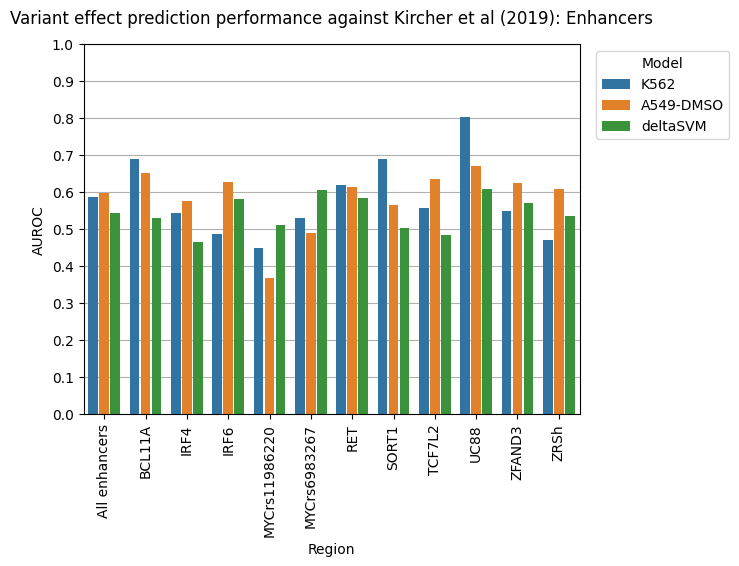

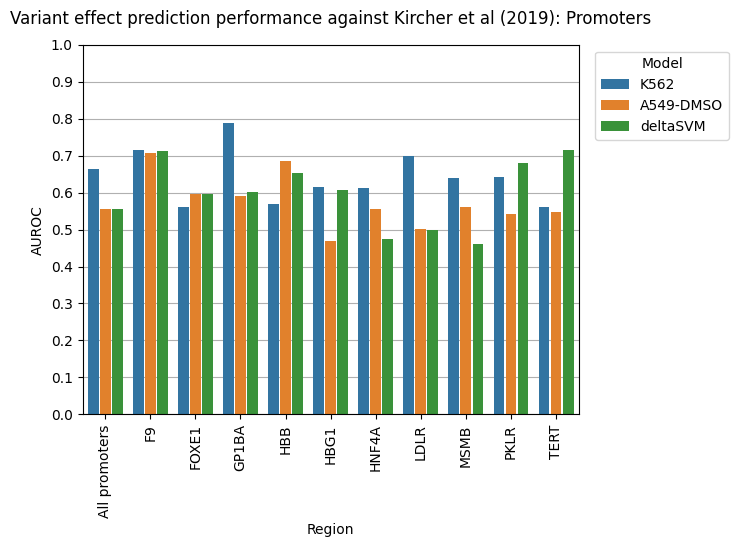

In [ ]:
for region_type in np.sort(next(iter(bk_dfs.values()))['region_type'].unique()):
    # change bk_dfs.items() to bk_dfs_filtered.items() if you want to exclude regions filtered out
    sub_dfs = {k: df[df['region_type'] == region_type] for k, df in bk_dfs.items()}
    sub_aucs = pd.DataFrame(generate_aucs_by(sub_dfs, subset_by='region', all_name=f'All {region_type.lower()}'))
    ax = sns.barplot(data=sub_aucs, x='subset', y='auroc', hue='model', gap=0.1)
    ax.set_ylabel('AUROC')
    ax.set_xlabel('Region')
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.01, 0.1, ))
    ax.tick_params(axis='x', labelrotation=90)
    ax.yaxis.grid(True)
    ax.set_axisbelow(True)
    ax.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
    _ = ax.set_title(f'Variant effect prediction performance against Kircher et al (2019): {region_type}', pad=15)
    plt.show()
    plt.close()